<center>Progetto realizzato da Elena Curti (matr. 185431)

# Sentiment analysis – Amazon reviews
</center>

## Introduzione
... realizzato con MongoDB. richiesto python 3.6 - 3.10. ... 


In [1]:
# !pip install happiestfuntokenizing tensorflow


In [2]:
import nltk
import random
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment.util import mark_negation, extract_unigram_feats
from nltk.corpus import wordnet as wn
from pymongo import MongoClient
from happiestfuntokenizing.happiestfuntokenizing import Tokenizer
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.pipeline import Pipeline
from nltk.sentiment.sentiment_analyzer import SentimentAnalyzer
from nltk.sentiment.util import demo_liu_hu_lexicon
from io import StringIO
import sys

client = MongoClient('192.168.202.128', 27017)      # TODO mettere localhost
DATABASE = client.test

In [3]:
import os, sys

class HiddenPrints:
    """ Classe usata per evitare alcune print """
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


In [4]:
def get_train_test_set(reviews):
    classi = list(set(list({x[1] for x in reviews})))

    # Creo un dizionario con chiavi le classi e valori una lista di indici delle review di tale classe
    diz_classe_indice = {c:[] for c in classi}
    cont = 0 
    for (r,c) in reviews:
        diz_classe_indice[c].append(cont)
        cont += 1
    
    # Inserisco nel train set e nel test set un numero 
    trainSet = []
    testSet = []
    for (c, indici) in diz_classe_indice.items():
        indexes = random.sample(indici, len(indici))
        int_index = int(len(indici)/2)
        trainSet += [reviews[i] for i in indexes[:int_index]] 
        testSet += [reviews[i] for i in indexes[int_index:]]
    return trainSet, testSet

    
def getReviewData(lista_overall, limite=100, field="reviewText", funzione_tokenize=None):
    reviews = []
    for overall in lista_overall:
        for review in DATABASE.reviews.find({"overall": overall}).limit(limite):
            if funzione_tokenize == None:
                reviews.append((review[field],str(overall))) 
            else:
                reviews.append(([i.lower() for i in funzione_tokenize(review[field])],str(overall))) 
            
    random.shuffle(reviews) 
    return reviews  

def perform_cross_validation(classifier, train_set):
    data = [i for (i, _) in train_set]
    target = [j for (_, j) in train_set]
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    scores = train_test_split(classifier, data, target)
    return sum(scores)/len(scores)
   
def get_classifier_and_mean_accuracy(reviews):
    """Questa funzione ritorna il classifier e la relativa accuracy media (test eseguiti su 50 run).  
    In input è richiesta la lista delle reviews. 
    Se feature e' 1 (default) viene usata la funzione extract_unigram_feats. 
    TODO Se feature e' 2 viene usato nltk.sentiment.util.demo_liu_hu_lexicon. In questo caso:
        - sono permesse solo le due classi 1.0 e 5.0. 
        - reviews deve essere una lista di tuple del tipo (testo_della_recensione, classe) dove testo_della_recensione e' una stringa.
    """
    # Run dei test e accuracy
    dim = 100 #int(len(reviews)/3)-1
    accuracy = []

    # classi = list(set(list({x[1] for x in reviews})))
    # classe_indice = {c:[] for c in classi}
    # cont =0 
    # for (r,c) in reviews:
    #     classe_indice[c].append(cont)
    #     cont += 1

    
    

    # Sentiment analyzer e applicazione delle feature
    sentimAnalyzer = SentimentAnalyzer() 
    allWordsNeg = sentimAnalyzer.all_words([mark_negation(doc) for doc in reviews])    
    unigramFeats = sentimAnalyzer.unigram_word_feats(allWordsNeg, min_freq=4)   
    sentimAnalyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigramFeats)
    featureSets = sentimAnalyzer.apply_features(reviews)
    for i in range(50):   # TODO metti 50
        # TODO chiedere in input 1000 reviews e prenderne 100 ad ogni giro di questo for. Mettere poi i codici sopra dentro al for

        # trainSet = []
        # testSet = []
        # for (c, indici) in classe_indice.items():
        #     indexes = random.sample(indici, len(indici))
        #     int_index = int(len(indici)/2)
        #     trainSet += [featureSets[i] for i in indexes[:int_index]] 
        #     testSet += [featureSets[i] for i in indexes[int_index:]]
         
        trainSet, testSet = get_train_test_set(featureSets)
        # trainSet, testSet = featureSets[dim:], featureSets[:dim]  
        with HiddenPrints():
            classifier = sentimAnalyzer.train(NaiveBayesClassifier.train, trainSet)
            evalu = sentimAnalyzer.evaluate(testSet)
        accuracy.append(evalu["Accuracy"])
    
    return classifier, round(sum(accuracy)/len(accuracy), 2) #perform_cross_validation(classifier, trainSet) #dict(sorted(sentimAnalyzer.evaluate(testSet).items()))
    # else:
    #     dev_test = [ (reviews[i][0], featureSets[i][0], featureSets[i][1]) for i in range(dim,len(reviews)-dim)]
    #     return classifier, dev_test

def print_accuracy(diz):
    print("Accuracy:", diz["Accuracy"])

    return
    for key,value in list_items:
        print('{0}: {1}'.format(key, value))

## Versione 1 (originale): World tokenizer di nltk con due classi

In [5]:
# TODO rimuovi commenti
reviews1 = getReviewData([1.0, 5.0], funzione_tokenize=nltk.word_tokenize)
classifier1, accuracy1 = get_classifier_and_mean_accuracy(reviews1)
print(accuracy1)

0.8


## Versione 2: Sentiment tokenizer di Christopher Potts con due classi

In [6]:
reviews2 = getReviewData([1.0, 5.0], funzione_tokenize=Tokenizer().tokenize)
classifier2, accuracy2 = get_classifier_and_mean_accuracy(reviews2)
print(accuracy2)

0.8


## Versione 3: Classificazione a cinque classi

In [7]:
# TODO rimuovi limite di 100 
reviews3 = getReviewData([float(i) for i in range(1,6)],limite=100, funzione_tokenize=nltk.word_tokenize)
classifier3, accuracy3 = get_classifier_and_mean_accuracy(reviews3)
print(accuracy3)

0.38


## Confronto tra le versioni
L'accuracy migliore è stata ottenuta con il sentiment tokenizer di Christopher Potts (<MARK>METTERE VALORE MEDIO</mark>). <br>
L'accuracy peggiore, invece, è stata ottenuta con la versione a cinque classi  (<MARK>METTERE VALORE MEDIO</mark>). <br>
L'accuracy della versione originale a due classi con nltk è a metà tra le due precedenti  (<MARK>METTERE VALORE MEDIO</mark>). 

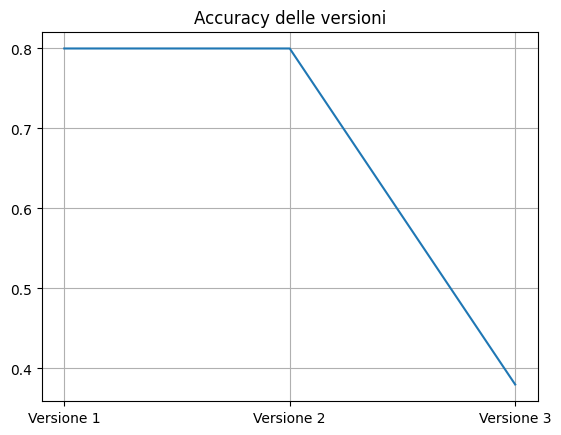

In [8]:
import matplotlib.pyplot as plt
x_plot = ["Versione 1", "Versione 2", "Versione 3"]
y_plot = [accuracy1, accuracy2, accuracy3]
plt.plot(x_plot, y_plot, label = "line 2")
plt.title('Accuracy delle versioni')
plt.grid()


## Cambio di feature
Per cercare di aumentare la accuracy, proverò ora a cambiare le feature.

### Versione 4: Uso del field "summary"

In [9]:
reviews4 = getReviewData([1.0, 5.0],field="summary", funzione_tokenize=nltk.word_tokenize)
classifier4, accuracy4 = get_classifier_and_mean_accuracy(reviews4)
print(accuracy4)

0.68


### Versione 5: uso dei soli aggettivi

In [10]:
reviews5 = []
for (lista_parole,classe) in reviews1:
    solo_aggettivi = []
    for par in lista_parole:
        tmp = wn.synsets(par)
        if len(tmp) > 0 and tmp[0].pos() == "a":
            solo_aggettivi.append(par)
    if solo_aggettivi != []:
        reviews5.append((solo_aggettivi,classe)) 

classifier5, accuracy5 = get_classifier_and_mean_accuracy(reviews5)
print(accuracy5)

0.55


### Versione 6: uso della frequency word invece della occurrence
<mark> TODO

In [12]:
accuracy6 = 0

## Uso della libreria Scikit-learn
Proverò ora a passare alla libreria "Scikit-learn". 


### Versione 7: Classificatore Support Vector Machines (SVM)
Nelle versioni viste finora, ho sempre fatto uso del classificatore Naive Bayes di nltk. Proverò ora a modificarlo, per cercare di migliorare l'accuracy.

In [13]:
# Creo il train e test set
reviews7 = getReviewData([1.0, 5.0], limite=1000)

trainSet, testSet = get_train_test_set(reviews7)

train_data, train_target = list(map(list, zip(*trainSet)))
test_data, test_target = list(map(list, zip(*testSet)))

# Classificatore
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),('clf', svm.SVC()),])
text_clf.fit(train_data, train_target)
predicted = text_clf.predict(test_data)

# Cross-validation
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
scores = cross_val_score(text_clf, test_data, test_target, cv=cv)
accuracy7 = round(sum(scores)/len(scores), 2)
print(accuracy7)


0.87


### Versione 8: Grid-search

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

reviews8 = getReviewData([1.0, 5.0], limite=1000)


classe_indice = {c:[] for c in ["1.0", "5.0"]}
cont = 0 
for (r,c) in reviews8:
    classe_indice[c].append(cont)
    cont += 1
trainSet = []
testSet = []

for (c, indici) in classe_indice.items():
        indexes = random.sample(indici, len(indici))
        int_index = int(len(indici)/2)
        trainSet += [reviews8[i] for i in indexes[:int_index]] 
        testSet += [reviews8[i] for i in indexes[int_index:]]

train_data, train_target = list(map(list, zip(*trainSet)))
test_data, test_target = list(map(list, zip(*testSet)))

text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),('clf', MultinomialNB()),])
text_clf.fit(train_data, train_target)

parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3),}
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

gs_clf = GridSearchCV(text_clf, parameters, cv=cv, n_jobs=-1)
gs_clf = gs_clf.fit(train_data, train_target)
predicted = gs_clf.predict(test_data)

scores = cross_val_score(text_clf, test_data, test_target, cv=cv)
accuracy8 = round(sum(scores)/len(scores), 2)

print("Accuracy: ", accuracy8)

Accuracy:  0.89


<mark> TODO mettere come vesione 6? o togliere?

In [14]:
def mio_demo_liu_hu_lexicon(sentence):
    """ Questo codice e' lo stesso della funzione nltk.sentiment.util.demo_liu_hu_lexicon, ma: 
    - al posto di print("Positive") ho messo return {"sent":"Positive"}. Stessa cosa per "Negative" e "Neutral". 
    - Inoltre, ho permesso di dare in input alla funzione una lista di stringhe, invece che una stringa
    """
    from nltk.corpus import opinion_lexicon
    from nltk.tokenize import treebank

    
    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0

    if not type(sentence) is list:
        tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]
    else:
        tokenized_sent = [word.lower() for word in sentence]

    x = list(range(len(tokenized_sent)))  # x axis for the plot
    y = []

    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            pos_words += 1
            y.append(1)  # positive
        elif word in opinion_lexicon.negative():
            neg_words += 1
            y.append(-1)  # negative
        else:
            y.append(0)  # neutral

    if pos_words > neg_words:
        return {"sent":"Positive"}
    elif pos_words < neg_words:
        return {"sent":"Negative"}
    elif pos_words == neg_words:
        return {"sent":"Neutral"}

In [ ]:
reviews9 = getReviewData([1.0, 5.0], limite=50)
dim = 100
accuracy = []
sentimAnalyzer = SentimentAnalyzer() 
# allWordsNeg = sentimAnalyzer.all_words([mark_negation(doc) for doc in reviews9])    
# unigramFeats = sentimAnalyzer.unigram_word_feats(allWordsNeg, min_freq=4)   
# sentimAnalyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigramFeats)
sentimAnalyzer.add_feat_extractor(mio_demo_liu_hu_lexicon)
featureSets = sentimAnalyzer.apply_features(reviews9, labeled=True)


classe_indice = {c:[] for c in ["1.0", "5.0"]}
cont =0 
for (r,c) in reviews9:
    classe_indice[c].append(cont)
    cont += 1

new_featset = [] 
for i in featureSets.iterate_from(0):
    new_featset.append(i)


for i in range(50):   # TODO metti 50
    trainSet = []
    testSet = []
    for (c, indici) in classe_indice.items():
        indexes = random.sample(indici, len(indici))
        int_index = int(len(indici)/2)
        trainSet += [new_featset[i] for i in indexes[:int_index]] 
        testSet += [new_featset[i] for i in indexes[int_index:]]

    with HiddenPrints():
        classifier = sentimAnalyzer.train(NaiveBayesClassifier.train, trainSet)
        evalu = sentimAnalyzer.evaluate(testSet)
    accuracy.append(evalu["Accuracy"])

classifier, accuracy9 = classifier, round(sum(accuracy)/len(accuracy), 2) #perform_cross_validation(classifier, trainSet) #dict(sorted(sentimAnalyzer.evaluate(testSet).items()))
accuracy9

# reviews9


0.71

In [20]:
accuracy8=0

### Hyperlane

In [16]:
from sklearn.linear_model import SGDClassifier

# Creo il train e test set
reviews10 = getReviewData([1.0, 5.0], limite=1000)


classe_indice = {c:[] for c in ["1.0", "5.0"]}
cont = 0 
for (r,c) in reviews10:
    classe_indice[c].append(cont)
    cont += 1
trainSet = []
testSet = []

for (c, indici) in classe_indice.items():
        indexes = random.sample(indici, len(indici))
        int_index = int(len(indici)/2)
        trainSet += [reviews10[i] for i in indexes[:int_index]] 
        testSet += [reviews10[i] for i in indexes[int_index:]]


train_data, train_target = list(map(list, zip(*trainSet)))
test_data, test_target = list(map(list, zip(*testSet)))

# Classificatore
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),])
text_clf.fit(train_data, train_target)
predicted = text_clf.predict(test_data)

# Cross-validation
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
scores = cross_val_score(text_clf, test_data, test_target, cv=cv)
accuracy10 = round(sum(scores)/len(scores), 2)
print(accuracy10)


0.86


## Risultati

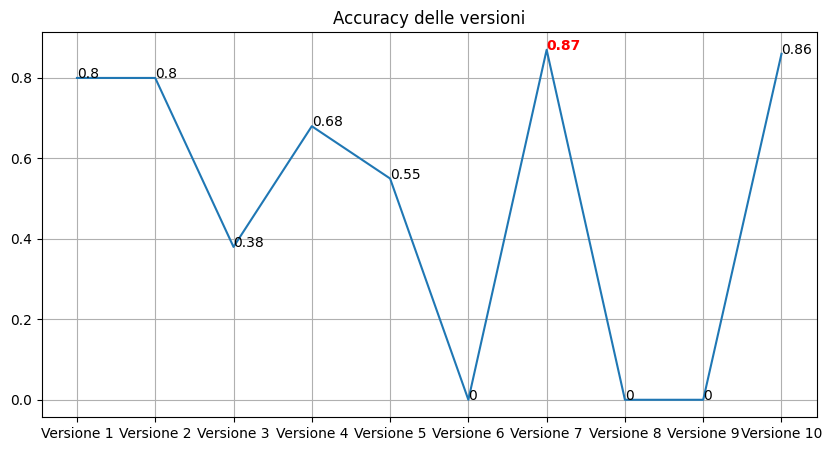

In [21]:
num_versioni = 10
x_titoli = []
y_accuracy = []
for i in range(1, num_versioni+1):
    eval("x_titoli.append('Versione "+str(i)+"')")
    eval("y_accuracy.append(accuracy"+str(i)+")")
plt.rcParams["figure.figsize"] = (10,5)

plt.plot(x_titoli, y_accuracy)
for i in range(num_versioni):
    if y_accuracy[i] == max(y_accuracy):
        plt.text(x_titoli[i], y_accuracy[i], str(y_accuracy[i]), color="red", weight='bold')
    else:
        plt.text(x_titoli[i], y_accuracy[i], str(y_accuracy[i]))

plt.title('Accuracy delle versioni')
plt.grid()
